In [88]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import statsmodels.api as sm
import csv

In [65]:
def FindNoise(file_name, dFrame):
    """
    Helper function to display experimental noise in a data set 
    @param file_name: name of file/data set 
    @param dFrame: pandas df containing dataset 
    """
    duplicates = dFrame[dFrame.duplicated(subset = ['Compound', 'T, K'], keep = False)]

    groups = duplicates.groupby(['Compound', 'T, K']).describe().reset_index()

    # SE is the standard error for each group
    groups['SE'] = groups['B, cm3/mol^-1', 'std'] / np.sqrt(groups['B, cm3/mol^-1', 'count'])

    # scatter plot of temperature and STD (color of points is the compound)
    groups['compoundLabel'] = groups['Compound', ''].rank(method='dense', ascending=False).astype(int)
    groups.plot.scatter(x=('T, K', ''), y=('B, cm3/mol^-1', 'std'), c='compoundLabel', cmap='gist_rainbow', title = file_name)

    # scatter plot of temperature and SE (color of points is the compound)
    groups.plot.scatter(x=('T, K', ''), y=('SE', ''), c='compoundLabel', cmap='gist_rainbow', title = file_name)

AttributeError: 'AxesSubplot' object has no attribute 'fig'

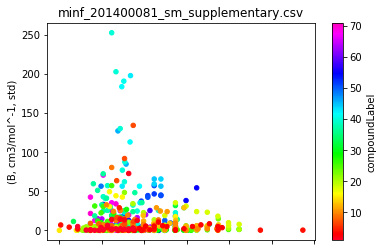

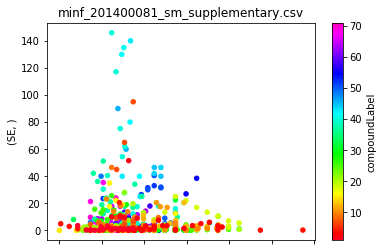

In [64]:
csv_file1 = os.path.join('Desktop', 'minf_201400081_sm_supplementary.csv') 
dFrame = pd.read_csv(csv_file1, usecols = [0,1,2])
FindNoise('minf_201400081_sm_supplementary.csv', dFrame)

1211


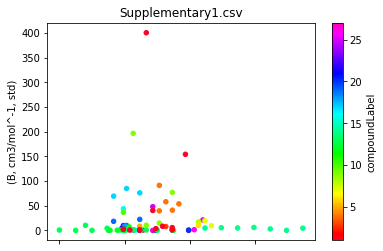

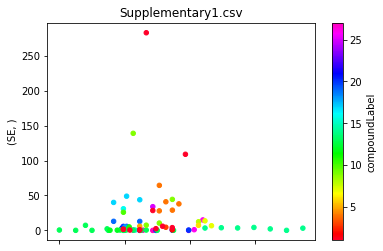

In [39]:
csv_file2 = os.path.join('Desktop', 'Supplementary1.csv')
dFrame2 = pd.read_csv(csv_file2, usecols = [0,1,2])
dFrame2.columns = ['Compound', 'T, K', 'B, cm3/mol^-1' ]
FindNoise('Supplementary1.csv', dFrame2)

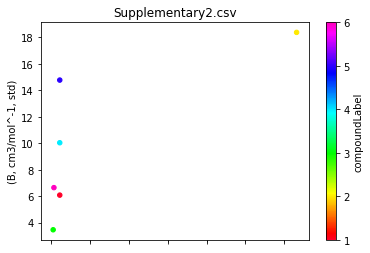

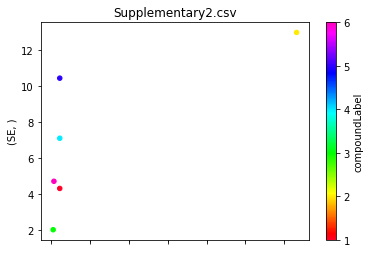

In [66]:
csv_file3 = os.path.join('Desktop', 'Supplementary2.csv')
dFrame3 = pd.read_csv(csv_file3, usecols = [0,1,2])
dFrame3.columns = ['Compound', 'T, K', 'B, cm3/mol^-1' ]
FindNoise('Supplementary2.csv', dFrame3)

In [42]:
# for further calculations, we are using these 3 dataframes, built from each file
dFrame = dFrame.rename(columns={"B, cm3/mol^-1":"B", "T, K":"T"})
dFrame2 = dFrame2.rename(columns={"B, cm3/mol^-1":"B", "T, K":"T"})
dFrame3 = dFrame3.rename(columns={"B, cm3/mol^-1":"B", "T, K":"T"})

# for each data frame, we are making a dictionary of dataframes corresponding to each compound
# these will be the datasets referred to in the following code

compound_data_1 = dict()
for compound in dFrame.Compound.unique(): 
    compound_data_1[compound] = dFrame[dFrame['Compound']==compound]  

compound_data_2 = dict()
for compound in dFrame2.Compound.unique(): 
    compound_data_2[compound] = dFrame2[dFrame2['Compound']==compound] 

compound_data_3 = dict()
for compound in dFrame3.Compound.unique(): 
    compound_data_3[compound] = dFrame3[dFrame3['Compound']==compound] 

all_data = [compound_data_1, compound_data_2, compound_data_3] # list holding each dataset
file_names = ['minf_201400081_sm_supplementary.csv', 'Supplementary1.csv', 'Supplementary2.csv'] # filenames corresponding to each dataset

126
261


In [90]:
single_linear_regressions_pdfs = ["one_regression_dataset1", "one_regression_dataset2", "one_regression_dataset3"]

In [95]:
# intially, just fitting a single linear regression and calculating errors to see how well the data conforms to 
#    the model a+b/t for each dataset

# dictionaries to store mean relative errors and mean absolute errors by compound
MAEs = defaultdict(float)
MREs = defaultdict(float)

# dictionary to store fit constants a and b by compound
one_regression_fit_constants = defaultdict(list)

# lists to store MREs and MAEs by compound for each dataset 
# i.e. all_MAES[0] stores MAEs for regressions performed on each compound in the first dataset
all_MAES = []
all_MRES = []

# used to save data in CSVs
all_one_regression_fit_constants = [] # list to store fit constants by compound for each dataset

# for each dataset,fitting a linear regression for each compound, finding error, and plotting it as to 
#    satisfy the equation a + b/t
for ind, dataset in enumerate(all_data): 
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(single_linear_regressions_pdfs[ind])
    
    for compound in dataset:
        xl = np.reciprocal(dataset[compound]['T'].tolist()) #using reciprocals of T
        x = np.asarray(xl)
        y = np.asarray(dataset[compound]['B'].tolist())

        x = x.reshape(len(x), 1)
        y = y.reshape(len(y), 1)

        # fitting model
        regr = linear_model.LinearRegression()
        regr.fit(x, y) 
    
        # display a and b values for the model a+b/t
        b = float(regr.coef_)
        a = float(regr.intercept_)
        print("b:" + str(b))
        print("a:" + str(a))
        one_regression_fit_constants[compound] = [a, b]
        y_predict = regr.predict(x)
    
        # calculating MAE and MRE of the compound and appending them to dictionary
        MAEs[compound] = np.mean(np.absolute(y_predict - y)) #adding MAE
        MREs[compound] = np.mean(np.absolute((y_predict - y)/y)) #adding MRE

        # plotting regression 
        plt.figure()
        plt.scatter(x, y)
        plt.xlim(0,max(xl)+0.001)
        plt.xlabel("1/T")
        plt.ylabel("B in cm3/mol^-1")
        plt.title(file_names[ind] + " - " + compound)
        plt.plot(x, y_predict)
        pdf.savefig() # saving plot to pdf
        plt.show() # displaying plot
        plt.close()
    
    pdf.close()
    
    all_one_regression_fit_constants.append(one_regression_fit_constants.copy())
    all_MAES.append(MAEs.copy())
    all_MRES.append(MREs.copy())
    
    one_regression_fit_constants.clear()
    MAEs.clear()
    MREs.clear()

In [96]:
# writing fit constants for one linear regression to CSV files corresponding to each dataset
one_regression_fit_constants_csvs = ["dataset1_1regr_fit_constants", "dataset2_1regr_fit_constants", 
                                     "dataset3_1regr_fit_constants" ]

for ind, dataset in enumerate(all_data):
    with open(one_regression_fit_constants_csvs[ind], 'w+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Gas Name", "a", "b", "MAE", "MRE"])
        for compound in dataset:
            writer.writerow([compound, all_one_regression_fit_constants[ind][compound][0],
                            all_one_regression_fit_constants[ind][compound][1], all_MAES[ind][compound], 
                            all_MRES[ind][compound]]

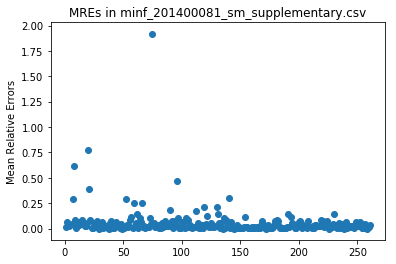

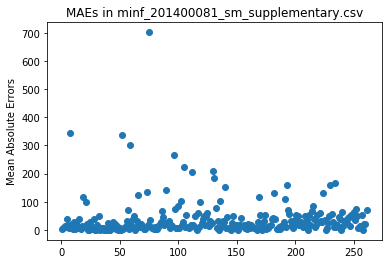

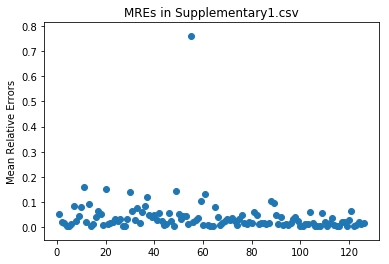

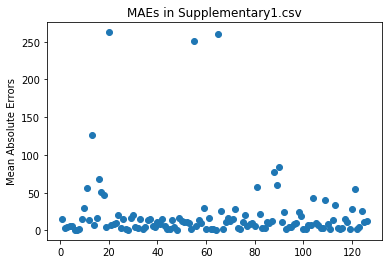

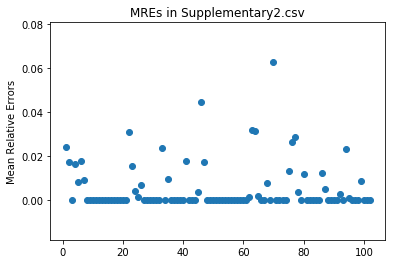

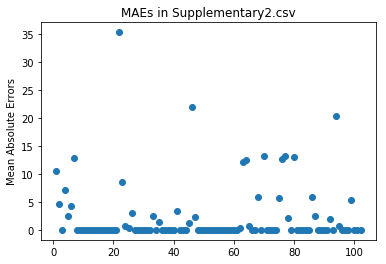

In [82]:
pdf = matplotlib.backends.backend_pdf.PdfPages("all_one_linear_regression_error_metrics")

# For each dataset, plotting all MREs and MAEs calculated above to view how well all compounds generally conform 
#    to a+b/t
for ind, dataset in enumerate(all_data):
    plt.figure()
    plt.scatter([num+1 for num in range(len(all_MRES[ind]))], list(all_MRES[ind].values()))
    plt.ylabel('Mean Relative Errors')
    plt.title('MREs in ' + file_names[ind])
    pdf.savefig() # saving plot 
    plt.show() # displaying plot
    plt.close()

    plt.figure()
    plt.scatter([num+1 for num in range(len(all_MAES[ind]))], list(all_MAES[ind].values()))
    plt.ylabel('Mean Absolute Errors')
    plt.title('MAEs in ' + file_names[ind])
    pdf.savefig() #saving plot
    plt.show() # displaying plot
    plt.close()

pdf.close()

In [48]:
# for each dataset, determining how many compounds fall within a "reasonable range" of MREs and MAEs
# "reasonable range" is determined to be compounds whose MRE and MAE is less than the median MRE and median MAE 
#     of all compounds 
for ind, dataset in enumerate(all_data):
    MRE_cutoff = np.median(list(all_MRES[ind].values()))
    MAE_cutoff = np.median(list(all_MAES[ind].values()))

    usable_compounds = []
    for compound in all_MAES[ind]:
        if all_MAES[ind][compound] <= MAE_cutoff and all_MRES[ind][compound] <= MRE_cutoff: 
            usable_compounds.append(compound)

    print("Number of compounds in reasonable range for " + file_names[ind] + " : " + str(len(usable_compounds)))
    print("Total number of compounds for " + file_names[ind] + " : " + str(len(dataset)))
    print('\n')

# conclusion: 
#    for dataset 1: 103/261 compounds fall in this "reasonable range"
#    for dataset 2: 50/126 compounds fall in this "reasonable range"
#    for dataset 3: 49/102 compounds fall in this "reasonable range"
# as this is less than 50% for every dataset, we go on to attempt multiple regressions to bring down 
#   these error margins

Number of compounds in reasonable range for minf_201400081_sm_supplementary.csv : 103
Total number of compounds for minf_201400081_sm_supplementary.csv : 261


Number of compounds in reasonable range for Supplementary1.csv : 50
Total number of compounds for Supplementary1.csv : 126


Number of compounds in reasonable range for Supplementary2.csv : 49
Total number of compounds for Supplementary2.csv : 102




In [84]:
two_linear_regressions_pdfs = ['two_regressions_dataset1', 'two_regressions_dataset2', 'two_regressions_dataset3']

With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regress

/Users/RoRo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars


With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regress

With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regress

With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regressions..
With ONE linear regression...
With TWO regress

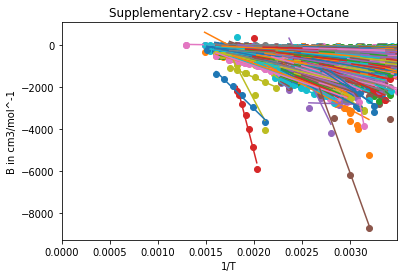

In [113]:
# for each dataset, attempting to fit 2 linear regressions for each compounds to reduce error margins
# this code is ultimately not vital, as the multiple_linear_regressions function performs x linear regressions
# this simply documents the process of discovering the benefits of more than one regressions

# dictionaries to store mean relative errors and mean absolute errors by compound 
MRE_percent_changes = []
MAEs = defaultdict(list)
MREs = defaultdict(list)

MRE_percent_change = [] # used to show MRE percent decrease

# used for saving data as CSVs
two_regressions_MREs = [] # stores MREs of each compound for each dataset when one and two regressions are performed
two_regressions_MAEs = [] # stores MAEs of each compound for each dataset when one and two regressions are performed
two_regression_fit_constants = defaultdict(list) # dictionary to store fit constants a1, a2, b1, b2 by compound
all_two_regression_fit_constants = [] # holds fit constants by compound for ALL datasets

# for each dataset, fitting 1 and 2 linear regressions for each compound, finding error, and plotting it
for ind, dataset in enumerate(all_data):
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(two_linear_regressions_pdfs[ind]) # saving plots w/ 2 regressions
    
    for compound in dataset:
        #fitting ONE linear regression
        print("With ONE linear regression...")
        xl = np.reciprocal(dataset[compound]['T'].tolist()) #using RECIPROCALS of T
        yl = dataset[compound]['B'].tolist()
        x = np.asarray(xl)
        y = np.asarray(yl)

        x = x.reshape(len(x), 1)
        y = y.reshape(len(y), 1)

        regr = linear_model.LinearRegression()
        regr.fit(x, y) # fitting model
        print("b:" + str(regr.coef_))
        print("a:" + str(regr.intercept_))
        y_predict = regr.predict(x)
       
        MAEs[compound].append(np.mean(np.absolute(y_predict - y))) # adding MAE when one regression is performed
        old_MRE = np.mean(np.absolute((y_predict - y)/y)) # used in percent change calcs
        MREs[compound].append(old_MRE) #adding MRE when one regression is performed

        # plotting single regression
        plt.scatter(x, y)
        plt.xlim(0,max(xl)+0.001)
        plt.xlabel("1/T")
        plt.ylabel("B in cm3/mol^-1")
        plt.title(file_names[ind] + " - " + compound)
        plt.plot(x, y_predict)
        plt.show() # displaying plot

        # fitting TWO separate regressions for each half of the compound data
        print("With TWO regressions..")
        
        # if two regressions can't be performed for a compound, all fit constants are set to NaN
        # this is useful when csv files are created from the data (see below)
        if len(xl) <= 1: 
            a1 = float("NaN")
            b1 = float("NaN")
            a2 = float("NaN")
            b2 = float("NaN")
            two_regression_fit_constants[compound] = [a1, b1, a2, b2]
            MAEs[compound].append(float("NaN"))
            MREs[compound].append(float("NaN"))
        
        # presuming enough data points to perform two linear regressions...
        else:
            xl_list = np.reciprocal(dataset[compound]['T'].tolist()).tolist()
            yl_list = dataset[compound]['B'].tolist()
    
            # splitting x and y values into two lists 
            xl_first_half = xl_list[:len(xl_list)//2]
            xl_second_half = xl_list[len(xl_list)//2:]
            yl_first_half = yl_list[:len(yl_list)//2]
            yl_second_half = yl_list[len(yl_list)//2:]
    
            x_first_half = np.asarray(xl_first_half)
            x_second_half = np.asarray(xl_second_half)
            y_first_half = np.asarray(yl_first_half)
            y_second_half = np.asarray(yl_second_half)
    
            x_first_half = x_first_half.reshape(len(x_first_half),1)
            x_second_half = x_second_half.reshape(len(x_second_half),1)
            y_first_half = y_first_half.reshape(len(y_first_half),1)
            y_second_half = y_second_half.reshape(len(y_second_half),1)
    
            # performing 2 linear regressions: 1 on the 1st half of x and y vals and 1 on the 2nd half of x and y vals
            regr.fit(x_first_half, y_first_half)
            b1 = float(regr.coef_)
            a1 = float(regr.intercept_)
            print("b1:" + str(b1))
            print("a1:" + str(a1))
            y_predict_first = regr.predict(x_first_half)

            regr.fit(x_second_half, y_second_half)
            b2 = float(regr.coef_)
            a2 = float(regr.intercept_)
            print("b2:" + str(b2))
            print("a2:" + str(a2))
            y_predict_second = regr.predict(x_second_half)

            two_regression_fit_constants[compound] = [a1, b1, a2, b2]
            
            # calculating MAEs by adding MAEs of each regression 
            first_half_absolute = np.absolute(y_predict_first - y_first_half)
            second_half_absolute = np.absolute(y_predict_second - y_second_half)
            MAEs[compound].append(np.mean(np.concatenate((first_half_absolute, second_half_absolute))))

            # calculating mean relative error and percent change in MRE from one regression to two regressions
            # doing percent change calcs for MRE rather than MAE because of variance in data from compound to compound
            if 0 not in y_first_half and 0 not in y_second_half:
                first_half_relative = np.absolute((y_predict_first - y_first_half)/y_first_half)
                second_half_relative = np.absolute((y_predict_second - y_second_half)/y_second_half)
                new_MRE = np.mean(np.concatenate((first_half_relative, second_half_relative)))
                MREs[compound].append(new_MRE)
                MRE_percent_change.append((new_MRE - old_MRE)/old_MRE * 100)
  
          # plotting both regressions on same plot
            plt.figure()
            plt.scatter(x, y)
            plt.xlim(0,max(xl)+0.001)
            plt.xlabel("1/T")
            plt.ylabel("B in cm3/mol^-1")
            plt.title(file_names[ind] + " - " + compound)
            plt.plot(x_first_half, y_predict_first)
            plt.plot(x_second_half, y_predict_second)
            pdf.savefig() # saving plot
            plt.show() # displaying plot
            plt.close()
            
            print("MAEs" + str(MAEs[compound])) 
            print("MREs" + str(MREs[compound]))
            print('\n')
            print('\n')

    pdf.close()
    
    average_MRE_percent_decrease = np.nanmean(MRE_percent_change)
    median_MRE_percent_decrease = np.nanmedian(MRE_percent_change)
    
    all_two_regression_fit_constants.append(two_regression_fit_constants.copy())
    two_regressions_MREs.append(MREs.copy())
    two_regressions_MAEs.append(MAEs.copy())
    MREs.clear()
    MAEs.clear()
    two_regression_fit_constants.clear()
    
    print("Average MRE percent change for " + file_names[ind] + " is " + str(average_MRE_percent_decrease) + "%")        
    print("Median MRE percent change median for " + file_names[ind] + " is " + str(median_MRE_percent_decrease) + "%") 

# conclusion:
#    for dataset 1: When two linear regressions are used, MRE decreases an average of 65.8%
#                   and the median MRE percent decrease is 67.3% 
#    for dataset 2: When two linear regressions are used, MRE decreases an average of 63.4%
#                   and the median MRE percent decrease is 65.1% 
#    for dataset 3: When two linear regressions are used, MRE decreases an average of 67.7%
#                   and the median MRE percent decrease is 71.7% 

# Clearly, performing multiple regressions makes significant changes to error margins, so we will go onto investigate
#    the benefits and consequences of performing multiple linear regressions

In [53]:
# helper function to split a list into wanted_parts sublists
def split_list(alist, wanted_parts=1): 
    """
    Helper function to split a list into sublists 
    @param alist: list to be split into parts
    @param wanted_parts: number of parts to split the list into 
    """
    length = len(alist) 
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts) ]

In [103]:
def multiple_linear_regressions(dataset, file_name, compound, num_regressions, display_graphs=False): 
    """
    Function to perform x linear regressions on a compound's dataset using Akaike Info Criteria to determine if model 
    improved, considering extra params
    @param dataset: data frame corresponding to one of 3 datasets
    @param file_name: file name corresponding to dataset
    @param compound: string denoting the name of the compound, whose data is found in compound_data dictionary 
    @param num_regressions: number of linear regressions to be performed 
    @param display_graphs: boolean flag. if true, display graphs, else no display
    @return: list containing AIC, and x,y data to graph
    """
    print("With %d regressions.." % num_regressions)
    xl_list = np.reciprocal(dataset[compound]['T'].tolist()).tolist()
    yl_list = dataset[compound]['B'].tolist()
    y_preds = []
    AIC = None
    
    if len(xl_list) >= num_regressions:
        # splitting list by number specified as num_regressions
        x_portions = split_list(xl_list, num_regressions)
        y_portions = split_list(yl_list, num_regressions) 
        regr = linear_model.LinearRegression()

        # performing regressions on each portion
        for portion in range(num_regressions):
            x_portions[portion] = np.asarray(x_portions[portion])
            x_portions[portion] = x_portions[portion].reshape(len(x_portions[portion]), 1)
            y_portions[portion] = np.asarray(y_portions[portion])
            y_portions[portion] = y_portions[portion].reshape(len(y_portions[portion]), 1)
    
    
            regr.fit(x_portions[portion], y_portions[portion])
            print("b" + str(portion+1) + ": " + str(regr.coef_))
            print("a" + str(portion+1) + ": " + str(regr.intercept_))

            predicted_y_vals = regr.predict(x_portions[portion])
            
            for val in predicted_y_vals: 
                y_preds.append(val[0])
                
        y_preds = np.asarray(y_preds)
  
        # plotting regressions if flag is set to true
        if display_graphs:
          # plotting both regression on same plot
            plt.scatter(xl_list, yl_list)
            plt.xlim(0,max(xl_list)+0.001)
            plt.xlabel("1/T")
            plt.ylabel("B in cm3/mol^-1")
            plt.title(file_name + " - " + compound)
            plt.plot(xl_list, y_preds)
            plt.show()
      
        # calculating maximum likelihood, which is to be used in AIC calcs
        max_likelihood = 0
        for i in range(len(yl_list)):
            max_likelihood += (y_preds[i] - yl_list[i])**2
        max_likelihood = max_likelihood/len(yl_list)
        
        
        K = 2 * num_regressions 
        n = len(xl_list)
        
        #using first order AIC for large samples (more than 40 datapoints), and second order for smaller samples (<40)
        if len(xl_list) > 40: 
            AIC = -2 * max_likelihood + 2 * K
        else:
            if n-K-1 != 0:
                AIC = -2* max_likelihood + 2*K + (2*K*(K+1)/(n-K-1))
        
    return [AIC, xl_list, yl_list, y_preds]

In [51]:
def find_optimal_num_regressions(dataset, file_name, compound):
    """
    Find optimal number of regressions based on the AIC calculated in multiple_linear_regressions
    @param dataset: data frame corresponding to one of 3 datasets
    @param file_name: file name corresponding to dataset
    @param compound: compound name string to reference compound_data
    @return: number of linear regressions that minimizes AIC
    """
    AIC_data = []
    
    # conducting 1...n/2 linear regressions where n is the length of the list
    #   this is because more than n/2 linear regressions is a linear interpolation (a direct line to each point)
    for num in range(1, len(dataset[compound])//2):#//2 + 1):
        data = multiple_linear_regressions(dataset, file_name, compound, num, False)
        AIC_data.append(data[0])
        xl_list = data[1]
        yl_list = data[2]
        y_preds = data[3]
        
    clean_AIC_data = [x for x in AIC_data if x is not None] #using AIC if it was able to be calculated
    
    if clean_AIC_data != []:
        optimal_num_regressions = clean_AIC_data.index(min(clean_AIC_data)) + 1
        
        # if AIC is minimized by more than one regression, display info 
        if optimal_num_regressions > 1:
            print("Num elements in dataset is " + str(len(dataset[compound])))
            print("Optimal number of regressions is " + str(optimal_num_regressions))
            print("AIC was " + str(min(clean_AIC_data)))
            plt.scatter(xl_list, yl_list)
            plt.xlim(0,max(xl_list)+0.001)
            plt.xlabel("1/T")
            plt.ylabel("B in cm3/mol^-1")
            plt.title(file_name + " - " + compound)
            plt.plot(xl_list, y_preds)
            plt.show()
        return optimal_num_regressions


In [54]:
# determining optimal number of regressions for each compound in each dataset 
for ind, dataset in enumerate(all_data):
    counter = 0
    for compound in dataset:
        optimal = find_optimal_num_regressions(dataset, file_names[ind], compound)
        if optimal is not None and optimal>1: # incrementing counter if optimal num regressions is greater than 0
            counter+=1
    print(counter)

# conclusion: for every dataset and for each compound, 1 linear regression is optimal 
#             (as we exclude n/2 linear regressions). 
#             however, when we perform 1..n linear regressions instead of 1..n/2 linear regressions, n/2 regressions
#             are optimal for compounds with fewer data points (<40). This may have to do with how AIC is calculated

0
0
0


In [114]:
# the following code is to generate a CSV with data about dual fits 
# note that some AIC values in this file may be large negative quantities. this is because the compound in question
#   likely only has very few data points (<=2). nonetheless, all AIC values are given for completeness.
all_AIC_data = []
AICs = defaultdict(float)

for ind, dataset in enumerate(all_data):
    for compound in dataset:
        result = multiple_linear_regressions(dataset, file_names[ind], compound, 2, False)
        if result[0] == None: 
            AICs[compound] = float("NaN")
        else:
            AICs[compound] = result[0]    
    all_AIC_data.append(AICs.copy())
    AICs.clear()

# writing fit constants for one linear regression to CSV files corresponding to each dataset
two_regression_fit_constants_csvs = ["dataset1_2regr_fit_constants", "dataset2_2regr_fit_constants", 
                                     "dataset3_2regr_fit_constants" ]

for ind, dataset in enumerate(all_data):
    with open(two_regression_fit_constants_csvs[ind], 'w+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Gas Name", "a1", "b1", "a2", "b2", "MAE", "MRE", "AIC"])
        for compound in dataset:
            writer.writerow([compound, all_two_regression_fit_constants[ind][compound][0],
                            all_two_regression_fit_constants[ind][compound][1], 
                            all_two_regression_fit_constants[ind][compound][2], 
                            all_two_regression_fit_constants[ind][compound][3], two_regressions_MAEs[ind][compound][1], 
                            two_regressions_MREs[ind][compound][1], 
                            all_AIC_data[ind][compound]])

With 2 regressions..
b1: [[-149326.9438573]]
a1: [209.41489689]
b2: [[-110566.4383769]]
a2: [95.54479609]
With 2 regressions..
b1: [[-162969.67133129]]
a1: [319.84796146]
b2: [[-116349.16264671]]
a2: [178.21754158]
With 2 regressions..
b1: [[-333870.11162006]]
a1: [651.44010436]
b2: [[-206191.57082227]]
a2: [271.59154692]
With 2 regressions..
b1: [[-264766.64251062]]
a1: [248.159696]
b2: [[-403209.74591578]]
a2: [577.08644097]
With 2 regressions..
b1: [[-1306100.28535776]]
a1: [2705.54990857]
b2: [[-662155.97506322]]
a2: [819.44725178]
With 2 regressions..
b1: [[-528448.53080296]]
a1: [1210.11446245]
b2: [[-302263.58945283]]
a2: [509.16189219]
With 2 regressions..
b1: [[-80819.48656341]]
a1: [182.85959305]
b2: [[-57110.77956775]]
a2: [109.25401878]
With 2 regressions..
b1: [[-5033999.86592886]]
a1: [14811.66798419]
b2: [[263361.25480456]]
a2: [-1093.26547231]
With 2 regressions..
b1: [[-318970.89029972]]
a1: [715.75659319]
b2: [[-182640.36314681]]
a2: [274.47867176]
With 2 regressions.

b1: [[-1715006.85236992]]
a1: [2852.59283786]
b2: [[-778893.68174359]]
a2: [1049.94459155]
With 2 regressions..
b1: [[-1249117.32236842]]
a1: [2035.23684211]
b2: [[-3580223.9445046]]
a2: [8903.37874839]
With 2 regressions..
b1: [[-1021587.73548387]]
a1: [1614.19354839]
b2: [[-977575.25637583]]
a2: [1468.36912752]
With 2 regressions..
b1: [[-908301.35188438]]
a1: [1533.79773936]
b2: [[-572769.60271073]]
a2: [709.81140453]
With 2 regressions..
b1: [[0.]]
a1: [-1021.3]
b2: [[0.]]
a2: [-953.7]
With 2 regressions..
b1: [[-2384898.4101073]]
a1: [6201.08305075]
b2: [[-483426.23336257]]
a2: [518.90389103]
With 2 regressions..
b1: [[0.]]
a1: [-1399.]
b2: [[-1081125.82888229]]
a2: [2004.46488625]
With 2 regressions..
b1: [[-496040.48324742]]
a1: [915.33173409]
b2: [[-306599.50179441]]
a2: [391.13665641]
With 2 regressions..
b1: [[-406767.92060211]]
a1: [718.31780876]
b2: [[-322350.23663961]]
a2: [447.88682678]
With 2 regressions..
b1: [[-1925576.64923989]]
a1: [3800.77659951]
b2: [[-1093704.9208

b2: [[0.]]
a2: [-1743.]
With 2 regressions..
b1: [[0.]]
a1: [-1950.]
b2: [[0.]]
a2: [-1716.5]
With 2 regressions..
b1: [[-1499818.68326657]]
a1: [2628.08809866]
b2: [[-1259517.0944743]]
a2: [1996.40763376]
With 2 regressions..
b1: [[-2273358.76984523]]
a1: [5384.88267599]
b2: [[-1201713.6667295]]
a2: [1975.15551367]
With 2 regressions..
b1: [[-1273593.31119747]]
a1: [1909.01137885]
b2: [[-776263.92249495]]
a2: [852.18993898]
With 2 regressions..
b1: [[-3279720.49610781]]
a1: [6567.64056152]
b2: [[-1705389.588556]]
a2: [2581.74946882]
With 2 regressions..
b1: [[-3529300.27808643]]
a1: [7198.2654321]
b2: [[-2239064.32993726]]
a2: [3922.34576662]
With 2 regressions..
b1: [[-2048111.89202945]]
a1: [3441.65200865]
b2: [[-1271795.84422265]]
a2: [1657.64339397]
With 2 regressions..
b1: [[-2708921.79680933]]
a1: [5436.0081831]
b2: [[-1544854.2299]]
a2: [2344.61805244]
With 2 regressions..
b1: [[-1979997.04905192]]
a1: [3358.93965424]
b2: [[-2010217.72983713]]
a2: [3422.21735326]
With 2 regress

b2: [[-701365.02804796]]
a2: [905.23021672]
With 2 regressions..
b1: [[-756836.37114754]]
a1: [1489.05901639]
b2: [[-245381.46290244]]
a2: [39.32381172]
With 2 regressions..
b1: [[-658784.76255574]]
a1: [965.43461006]
b2: [[-872241.41411583]]
a2: [1401.31768845]
With 2 regressions..
b1: [[-595182.144]]
a1: [886.92]
b2: [[-579399.41611332]]
a2: [845.25114865]
With 2 regressions..
b1: [[-1072741.1520536]]
a1: [2092.53415152]
b2: [[-748045.93180459]]
a2: [1167.16313531]
With 2 regressions..
b1: [[-1903918.46915887]]
a1: [4230.6728972]
b2: [[-899219.35145014]]
a2: [1477.52483115]
With 2 regressions..
b1: [[-734727.84]]
a1: [1023.2]
b2: [[-804812.3316124]]
a2: [1160.06421731]
With 2 regressions..
b1: [[-492125.13158734]]
a1: [418.9026259]
b2: [[-400400.27218137]]
a2: [230.06046874]
With 2 regressions..
b1: [[49545.4045792]]
a1: [-722.5453212]
b2: [[-90897.61640779]]
a2: [-413.7334943]
With 2 regressions..
b1: [[-879283.48217992]]
a1: [1181.4632769]
b2: [[-1588543.41646045]]
a2: [2705.154230